In [1]:
# code to fit arrhenius parameters to kinetics data given in separate forward and reverse directions

In [2]:
import rmgpy.chemkin
import os
import copy
import numpy as np

import scipy.optimize

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
chemkin_gas = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated-gas.inp'
chemkin_surf = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated-surface.inp'
spec_dict = '/home/moon/uncertainty_estimator/beef/cpox_Pt/species_dictionary.txt'

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(chemkin_gas, spec_dict, surface_path=chemkin_surf)

In [4]:
def get_reverse_reaction(reaction):
    assert reaction.kinetics is not None
    rev_reaction = copy.deepcopy(reaction)
    tmp_reactants = rev_reaction.reactants
    rev_reaction.reactants = rev_reaction.products
    rev_reaction.products = tmp_reactants
    rev_reaction.kinetics = reaction.generate_reverse_rate_coefficient()
    return rev_reaction

In [15]:
def plot_kinetics(rxns, labels=None):
    """Function for plotting reaction kinetics
    Takes in a list of RMG reactions (rmgpy.reaction.Reaction) or a single reaction
    """
    plt.xlabel('1000 / T (K^-1)')
    plt.ylabel('log10(k)')
    linestyles = ['solid', 'dashed', 'dotted']
    if type(rxns) != list:
        rxns = [rxns]

    T = np.linspace(300, 3000, 1001)
    for m, rxn in enumerate(rxns):
        k = np.zeros(len(T))
        for i in range(0, len(T)):
            try:
                k[i] = rxn.get_rate_coefficient(T[i], 101325, surface_site_density=2.4830E-05)  # mol/cm^2
            except NotImplementedError:
                k[i] = rxn.get_sticking_coefficient(T[i])
        plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[m % len(linestyles)])

    if labels:
        plt.legend(labels)
#     plt.show()

X(1) + X(1) + CH4(2) <=> HX(21) + CH3X(27)


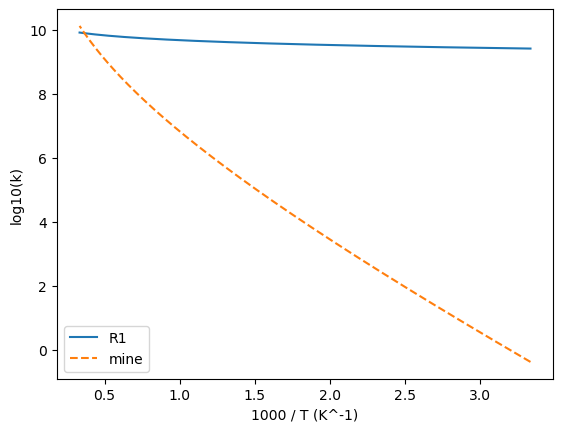

In [16]:
i = 68

my_R1 = get_reverse_reaction(reaction_list[i])
print(my_R1)
R1 = copy.deepcopy(my_R1)
R1.kinetics = rmgpy.kinetics.surface.StickingCoefficient(A=0.01, n=0, Ea=(0.0, 'cal/mol'))
plot_kinetics([R1, my_R1], ['R1', 'mine'])
# plot_kinetics([get_reverse_reaction(reaction_list[i])], [ 'mine'])

HX(21) + CH3X(27) <=> X(1) + X(1) + CH4(2)


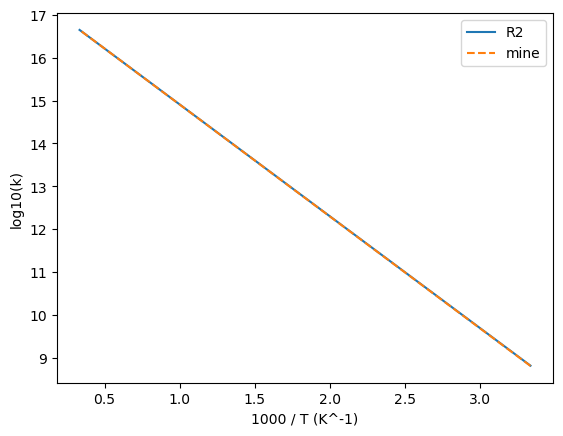

In [17]:
i = 68
print(reaction_list[i])

my_R2 = reaction_list[i]

R2 = copy.deepcopy(my_R2)
R2.kinetics = rmgpy.kinetics.surface.SurfaceArrhenius(A=(3.3e21, 'cm^2/(mol*s)'), n=0, Ea=(11942, 'cal/mol'))
plot_kinetics([R2, my_R2], ['R2', 'mine'])
# plot_kinetics([get_reverse_reaction(reaction_list[i])], [ 'mine'])

# Fit parameters

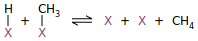

In [23]:
reaction_list[68]

In [24]:
R1.kinetics

StickingCoefficient(A=0.01, n=0, Ea=(0,'cal/mol'), T0=(1,'K'))

In [157]:
T0s = np.linspace(300, 2000, 11)
lnk0s = np.zeros_like(T0s)
k0s = np.zeros_like(T0s)

rev_lnk0s = np.zeros_like(T0s)
rev_k0s = np.zeros_like(T0s)
for i in range(len(T0s)):
    lnk0s[i] = np.log(reaction_list[68].get_rate_coefficient(T0s[i], 101325, surface_site_density=2.4830E-05))  # mol/m^2
    k0s[i] = reaction_list[68].get_rate_coefficient(T0s[i], 101325, surface_site_density=2.4830E-05)
    
    rev_lnk0s[i] = np.log(R1.get_rate_coefficient(T0s[i], 101325, surface_site_density=2.4830E-05))  # mol/m^2
    rev_k0s[i] = R1.get_rate_coefficient(T0s[i], 101325, surface_site_density=2.4830E-05)
    

In [158]:
#can we try fitting different kinetics to this such that the reverse also fits??
## Maybe prioritize the forward direction with 75% weight or something
R = 8.314

def my_fwd(Ts, lnA, b, Ea):
    lnks = lnA + b * np.log(Ts) - Ea / (rmgpy.constants.R * Ts)
    return lnks

In [159]:
p, cov = scipy.optimize.curve_fit(my_fwd, T0s, lnk0s, p0=[np.log(3.3e21), 0, 40000])
fitted_A, fitted_b, fitted_Ea = p

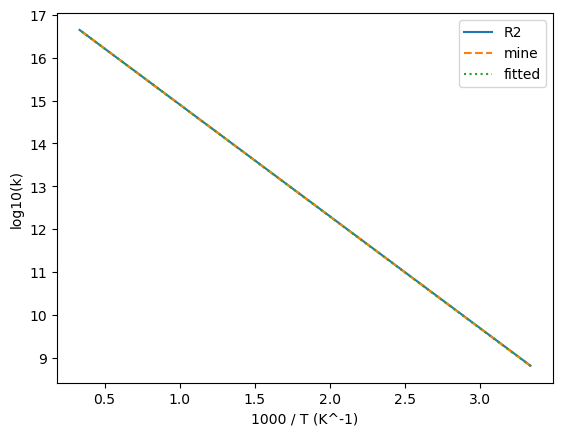

In [160]:
other_R2 = copy.deepcopy(my_R2)
other_R2.kinetics = rmgpy.kinetics.surface.SurfaceArrhenius(A=(np.exp(fitted_A), 'm^2/(mol*s)'), n=fitted_b, Ea=(fitted_Ea, 'J/mol'))
plot_kinetics([R2, my_R2, other_R2], ['R2', 'mine', 'fitted'])
# plot_kinetics([R2, my_R2], ['R2', 'mine'])


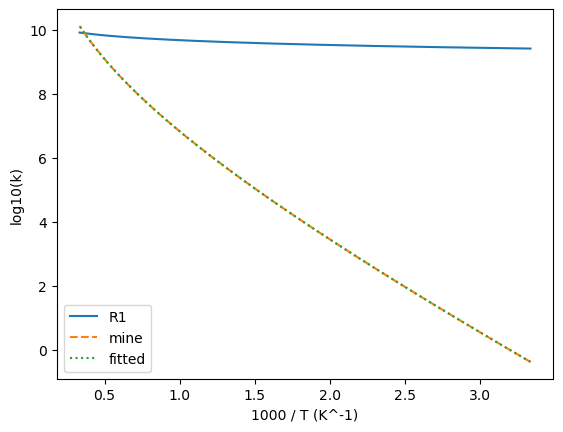

In [161]:
plot_kinetics([R1, get_reverse_reaction(my_R2), get_reverse_reaction(other_R2)], ['R1', 'mine', 'fitted'])

In [162]:
def cost_function(x):
    fwd_weight = 0.9
    lnA, b, Ea = x
    my_rxn_copy = copy.deepcopy(my_R2)
    test_lnks = np.zeros_like(T0s)
    rev_test_lnks = np.zeros_like(T0s)
    my_rxn_copy.kinetics = rmgpy.kinetics.SurfaceArrhenius(A=(np.exp(lnA), 'cm^2/(mol*s)'), n=b, Ea=(Ea, 'cal/mol'))
    for i in range(len(T0s)):
        test_lnks[i] = np.log(my_rxn_copy.get_rate_coefficient(T0s[i], 101325, surface_site_density=2.4830E-05))
        rev_test_lnks[i] = np.log(my_rxn_copy.generate_reverse_rate_coefficient().get_rate_coefficient(T0s[i], 101325))
    error = fwd_weight * np.sum(np.float_power(test_lnks - lnk0s, 2.0)) + (1.0 - fwd_weight) * np.sum(np.float_power(rev_test_lnks - rev_lnk0s, 2.0))
    return error

In [212]:
def cost_function_BEP(x):
    fwd_weight = 0.5
    lnA, b, E0, alpha = x
    my_rxn_copy = copy.deepcopy(my_R2)
    test_lnks = np.zeros_like(T0s)
    rev_test_lnks = np.zeros_like(T0s)
    my_rxn_copy.kinetics = rmgpy.kinetics.SurfaceArrheniusBEP(A=(np.exp(lnA), 'cm^2/(mol*s)'), n=b, E0=(E0, 'cal/mol'), alpha=alpha)
    
    original_kinetics = my_rxn_copy.kinetics
    
    for i in range(len(T0s)):
        test_lnks[i] = np.log(my_rxn_copy.get_rate_coefficient(T0s[i], 101325, surface_site_density=2.4830E-05))
        
        dHrxn = my_rxn_copy.get_enthalpy_of_reaction(T0s[i])
        reversible_kinetics = my_rxn_copy.kinetics.to_arrhenius(dHrxn)
        my_rxn_copy.kinetics = reversible_kinetics
        rev_test_lnks[i] = np.log(my_rxn_copy.generate_reverse_rate_coefficient().get_rate_coefficient(T0s[i], 101325))
        
        my_rxn_copy.kinetics = original_kinetics
    error = fwd_weight * np.sum(np.float_power(test_lnks - lnk0s, 2.0)) + (1.0 - fwd_weight) * np.sum(np.float_power(rev_test_lnks - rev_lnk0s, 2.0))
    return error

In [213]:
# sol = scipy.optimize.minimize(cost_function, [ 4.95482633e+01, -6.77916670e-06,  1.19500102e+04])
sol = scipy.optimize.minimize(cost_function_BEP, [  4.79619226e+01, -2.91373070e-02, 1.66779709e+03, 0.5], method='Powell',
                             bounds=[(None, None),(None, None),(0.0, None),(0.0, 1.0)])

In [214]:
# cost_function((fitted_A, fitted_b, fitted_Ea))

In [215]:
# # sol = scipy.optimize.minimize(cost_function, [ 4.95482633e+01, -6.77916670e-06,  1.19500102e+04])
# sol = scipy.optimize.minimize(cost_function, [  4.79619226e+01, -2.91373070e-02, -1.66779709e+03], method='Powell')

In [216]:
sol

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.95109232e-04, -3.39222297e-06,  5.13631461e-02,
        -4.19150758e-05],
       [ 5.17524244e-09,  2.70418251e-07,  5.20351352e-03,
        -2.68119177e-10]])
     fun: 248.814685839404
 message: 'Optimization terminated successfully.'
    nfev: 438
     nit: 4
  status: 0
 success: True
       x: array([5.38700791e+01, 4.96123008e-02, 3.56360916e+03, 1.70810485e-14])

In [217]:
cost_function_BEP(sol.x)

248.814685839404

In [218]:
sol.x

array([5.38700791e+01, 4.96123008e-02, 3.56360916e+03, 1.70810485e-14])

# BEP

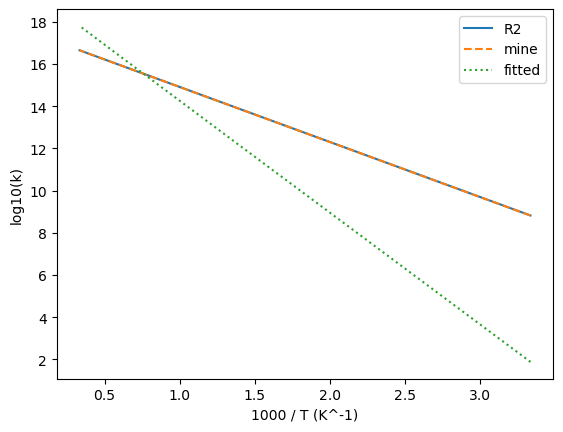

In [219]:
new_my_rxn_copy = copy.deepcopy(my_R2)
new_my_rxn_copy.kinetics = rmgpy.kinetics.SurfaceArrheniusBEP(A=(np.exp(sol.x[0]), 'cm^2/(mol*s)'), n=sol.x[1], E0=(sol.x[2], 'cal/mol'), alpha=sol.x[3])

original_kinetics = new_my_rxn_copy.kinetics
dHrxn = new_my_rxn_copy.get_enthalpy_of_reaction(1000)
# reversible_kinetics = new_my_rxn_copy.kinetics.to_arrhenius(dHrxn)
# new_my_rxn_copy.kinetics = reversible_kinetics

plot_kinetics([R2, my_R2, new_my_rxn_copy], ['R2', 'mine', 'fitted'])
# new_my_rxn_copy.kinetics = original_kinetics

In [220]:
original_kinetics.get_rate_coefficient(500)

9.370456034084622e+17

In [221]:
reversible_kinetics.get_rate_coefficient(500)

4.305056930509892e+18

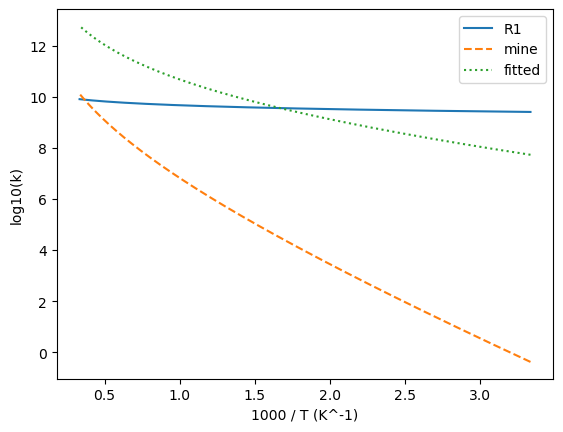

In [222]:
original_kinetics = new_my_rxn_copy.kinetics
dHrxn = new_my_rxn_copy.get_enthalpy_of_reaction(1000)
reversible_kinetics = new_my_rxn_copy.kinetics.to_arrhenius(dHrxn)
new_my_rxn_copy.kinetics = reversible_kinetics

plot_kinetics([R1, get_reverse_reaction(my_R2), get_reverse_reaction(new_my_rxn_copy)], ['R1', 'mine', 'fitted'])
new_my_rxn_copy.kinetics = original_kinetics


# Regular Arrhenius

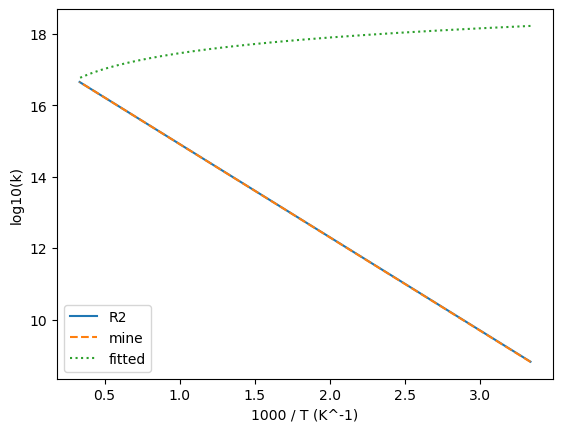

In [180]:
new_my_rxn_copy = copy.deepcopy(my_R2)
new_my_rxn_copy.kinetics = rmgpy.kinetics.SurfaceArrhenius(A=(np.exp(sol.x[0]), 'cm^2/(mol*s)'), n=sol.x[1], Ea=(sol.x[2], 'cal/mol'))

plot_kinetics([R2, my_R2, new_my_rxn_copy], ['R2', 'mine', 'fitted'])

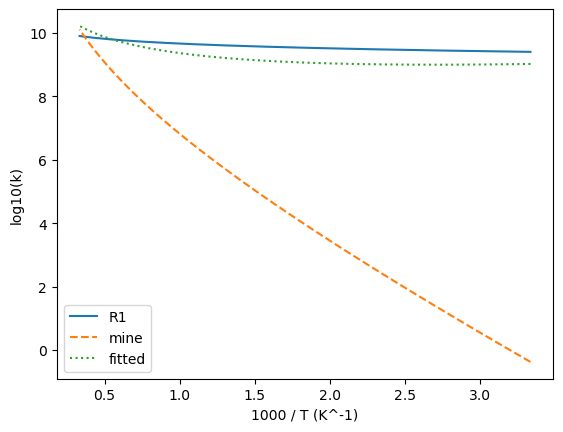

In [174]:
plot_kinetics([R1, get_reverse_reaction(my_R2), get_reverse_reaction(new_my_rxn_copy)], ['R1', 'mine', 'fitted'])